# **LAB SESSION 2 - Bagging and Random Forests**
# **CORRECTION**

## Utils

In [2]:
#conda install -c conda-forge scikit-learn, pandas 

In [3]:
#conda install seaborn

*Note: in all this project, use **the value 0** when you need to choose a value for a random state*

In [25]:
import numpy as np
import pandas as pd # data analysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

## Ex 1: comparison between CART, bagging and random forests 

We work with the [Urban Land Cover data base](https://archive.ics.uci.edu/ml/datasets/Urban+Land+Cover). The data are used for automated mapping of urban land cover (trees, grass, soil, concrete, asphalt, buildings, etc.) in satellite or aerial imagery. Nine types of urban land cover are considered and multi-scale spectral, size, shape, and texture information are used for classification. The data consists in a train set and a test set. **The goal is to predict the urban land cover (the variable named `class`) based on the multi-scale spectral, size, shape, and texture information.**

Before to start, we: 
 1) load the data and perform a briel descriptive analysis of them;
 2) select the variables that we will use in the exercise, 


In [26]:
# Load the data 
ulc_train = pd.read_csv("ULC_training.csv") 
ulc_test = pd.read_csv("ULC_testing.csv") 

In [27]:
# Display the dimension
print(ulc_train.shape)
print(ulc_test.shape)

(168, 148)
(507, 148)


In [28]:
# Have a first quick look at the datasets and display the dimension
ulc_train.head()

,class,BrdIndx,Area,Round,Bright,Compact,ShpIndx,Mean_G,Mean_R,Mean_NIR,...,SD_NIR_140,LW_140,GLCM1_140,Rect_140,GLCM2_140,Dens_140,Assym_140,NDVI_140,BordLngth_140,GLCM3_140
0,car,1.27,91,0.97,231.38,1.39,1.47,207.92,241.74,244.48,...,26.18,2.00,0.50,0.85,6.29,1.67,0.70,-0.08,56,3806.36
1,concrete,2.36,241,1.56,216.15,2.46,2.51,187.85,229.39,231.20,...,22.29,2.25,0.79,0.55,8.42,1.38,0.81,-0.09,1746,1450.14
2,concrete,2.12,266,1.47,232.18,2.07,2.21,206.54,244.22,245.79,...,15.59,2.19,0.76,0.74,7.24,1.68,0.81,-0.07,566,1094.04
3,concrete,2.42,399,1.28,230.40,2.49,2.73,204.60,243.27,243.32,...,13.51,3.34,0.82,0.74,7.44,1.36,0.92,-0.09,1178,1125.38
4,concrete,2.15,944,1.73,193.18,2.28,4.10,165.98,205.55,208.00,...,15.65,50.08,0.85,0.49,8.15,0.23,1.00,-0.08,6232,1146.38


In [29]:
ulc_test.head()

,class,BrdIndx,Area,Round,Bright,Compact,ShpIndx,Mean_G,Mean_R,Mean_NIR,...,SD_NIR_140,LW_140,GLCM1_140,Rect_140,GLCM2_140,Dens_140,Assym_140,NDVI_140,BordLngth_140,GLCM3_140
0,concrete,1.32,131,0.81,222.74,1.66,2.18,192.94,235.11,240.15,...,31.15,5.04,0.80,0.58,8.56,0.82,0.98,-0.10,1512,1287.52
1,shadow,1.59,864,0.94,47.56,1.41,1.87,36.82,48.78,57.09,...,12.01,3.70,0.52,0.96,7.01,1.69,0.86,-0.14,196,2659.74
2,shadow,1.41,409,1.00,51.38,1.37,1.53,41.72,51.96,60.48,...,18.75,3.09,0.90,0.63,8.32,1.38,0.84,0.10,1198,720.38
3,tree,2.58,187,1.91,70.08,3.41,3.11,93.13,55.20,61.92,...,27.67,6.33,0.89,0.70,8.56,1.10,0.96,0.20,524,891.36
4,asphalt,2.60,116,2.05,89.57,3.06,3.02,73.17,94.89,100.64,...,32.05,1.01,0.83,0.75,8.62,2.08,0.08,-0.10,496,1194.76


In [30]:
## Display a statistic summary for the numerical variables
ulc_train.describe(include='all')

,class,BrdIndx,Area,Round,Bright,Compact,ShpIndx,Mean_G,Mean_R,Mean_NIR,...,SD_NIR_140,LW_140,GLCM1_140,Rect_140,GLCM2_140,Dens_140,Assym_140,NDVI_140,BordLngth_140,GLCM3_140
count,168,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,...,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
unique,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,grass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.008512,565.869048,1.132976,165.569821,2.077679,2.229881,161.577083,163.672440,171.459226,...,23.769881,3.098274,0.796488,0.665000,7.795536,1.594405,0.615357,0.014583,983.309524,1275.292917
std,NaN,0.634807,679.852886,0.489150,61.883993,0.699600,0.703572,63.407201,71.306748,67.973969,...,12.836522,6.101883,0.103930,0.179086,0.670491,0.460627,0.239900,0.153677,880.013745,603.658611
min,NaN,1.000000,10.000000,0.020000,37.670000,1.000000,1.060000,30.680000,32.210000,40.120000,...,4.020000,1.000000,0.330000,0.240000,6.290000,0.230000,0.070000,-0.360000,56.000000,336.730000
25%,NaN,1.537500,178.000000,0.787500,133.977500,1.547500,1.700000,91.040000,101.187500,120.165000,...,13.965000,1.395000,0.757500,0.560000,7.357500,1.325000,0.460000,-0.080000,320.000000,817.405000
50%,NaN,1.920000,315.000000,1.085000,164.485000,1.940000,2.130000,187.560000,160.615000,178.345000,...,21.135000,1.740000,0.810000,0.690000,7.790000,1.660000,0.620000,-0.040000,776.000000,1187.025000
75%,NaN,2.375000,667.000000,1.410000,221.895000,2.460000,2.680000,210.940000,234.815000,236.002500,...,29.957500,2.285000,0.870000,0.810000,8.260000,1.945000,0.810000,0.120000,1412.500000,1588.427500


In [31]:
ulc_test.describe(include='all')

,class,BrdIndx,Area,Round,Bright,Compact,ShpIndx,Mean_G,Mean_R,Mean_NIR,...,SD_NIR_140,LW_140,GLCM1_140,Rect_140,GLCM2_140,Dens_140,Assym_140,NDVI_140,BordLngth_140,GLCM3_140
count,507,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,...,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000
unique,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,building,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.025720,562.504931,1.237574,165.612939,2.187081,2.277318,166.290355,162.291953,168.256667,...,24.601144,2.931657,0.817712,0.597732,8.048698,1.455838,0.653905,0.027436,1398.706114,1101.998185
std,NaN,0.619254,698.655240,0.561988,63.230806,0.874054,0.718441,59.217648,73.455101,69.702475,...,12.203441,4.942887,0.106007,0.197505,0.787912,0.451781,0.251287,0.133834,1097.323462,533.927869
min,NaN,1.000000,22.000000,0.000000,26.850000,1.000000,1.040000,22.910000,26.520000,31.110000,...,2.650000,1.000000,0.200000,0.100000,5.690000,0.240000,0.030000,-0.360000,34.000000,211.270000
25%,NaN,1.580000,159.000000,0.840000,127.485000,1.650000,1.715000,146.460000,97.585000,111.715000,...,14.485000,1.375000,0.770000,0.455000,7.370000,1.160000,0.470000,-0.080000,601.000000,726.745000
50%,NaN,1.950000,323.000000,1.210000,170.650000,2.000000,2.180000,189.630000,158.280000,167.750000,...,22.380000,1.920000,0.840000,0.610000,8.020000,1.440000,0.710000,-0.020000,1148.000000,1011.230000
75%,NaN,2.380000,681.500000,1.565000,224.825000,2.490000,2.675000,206.780000,237.375000,238.480000,...,33.825000,2.800000,0.890000,0.760000,8.750000,1.775000,0.860000,0.145000,1874.000000,1335.640000


In [32]:
## Display the distribution of the target variable in the two datasets
ulc_train['class'].value_counts()


class
grass        29
building     25
concrete     23
tree         17
shadow       16
car          15
pool         15
asphalt      14
soil         14
Name: count, dtype: int64

In [33]:
ulc_test['class'].value_counts()

class
building     97
concrete     93
tree         89
grass        83
shadow       45
asphalt      45
car          21
soil         20
pool         14
Name: count, dtype: int64

In [34]:
# Select the variables that we be used 
target_column = "class" # The response variable that we will consider
features_columns = list(ulc_train)
features_columns.remove('class') # The predictors/features used to predict the target
#print(target_column)
#print(features_columns)

In [35]:
data, target = ulc_train[features_columns], ulc_train[target_column]
data_test, target_test = ulc_test[features_columns], ulc_test[target_column]

**Question 1. Fit a random forest named *`rfc`* on the train set to explain the type of urban land cover (variable `class`) according to multi-scale spectral, size, shape, and texture information. More specifically, you will use the [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) class or [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor) class. Read carefully the documentation and choose between the [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) class or [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor) class. Before buiding *`rfc`* remind in the window below the meaning of`n_estimators` and `max_features`.**

**For the hyperparameters, use the values `n_estimators = 500` and `max_features= sqrt(d)` with `d` denoting the number of features, `oob_score=True`  and`random_state=0`.**




Solution: `n_estimators` is the number of trees in the forests and `max_features` is  the number of variables to randomly sample as candidates at each split.


In [15]:
## Solution

# Step 1: create the object rfc, it is a RandomForestClassifier object with n_estimators=500, max_features='auto' and random_state=0
rfc = RandomForestClassifier(n_estimators=500,oob_score=True,random_state=0)

# Step 2: build the random forest on the train set by indicating the input data and the target variable 
rfc.fit(data, target)

RandomForestClassifier(n_estimators=500, oob_score=True, random_state=0)

In [17]:
## Solution

# Step 3: look at the parameters used by your forest
print('Parameters of the forest:\n')
pprint(rfc.get_params())

Parameters of the forest:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': True,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


**Compute the oob error and comment the result. What does it represent ?**

In [18]:
# Step 4: print the OOB error
print('OOB error: ', round(1-rfc.oob_score_,2))

OOB error:  0.15


Solution : the oob error or out-of-bag error is a way to measure the prediction error of random forests. OOB error is the error rate measured on the out-of-bag samples (see the lesson). Here, the OOB error equal about 15%.

**Question 2. Predict the class of each observation of the test sample by using the random forest `rfc`and display the confusion matrix. Comment it. How many observations are misclassified ? Compute the accuracy.**

Accuracy estimated on the test set:  0.81


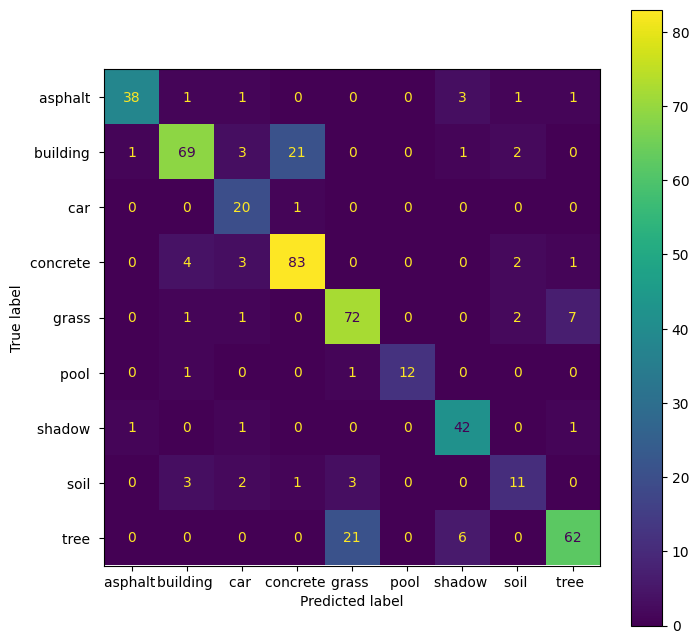

In [23]:
## Solution

# Step 1: compute the predictions
predictions_test = rfc.predict(data_test) 

# Step 2: display the confusion matrix
cm = confusion_matrix(target_test, predictions_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rfc.classes_)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax) 

# Step 3: compute the accuracy
accuracy = rfc.score(data_test,target_test)
print("Accuracy estimated on the test set: ",round(accuracy,2))


Solution for interpretation of the confusion matrix and the accuracy: we can see that some spectral images of tree (21+6) are wrongly classified as grass or shadow (or inversly 6 spectral images of grass classified as tree), same for 21 spectral images of building that are classified as concrete. 
The overall accuracy (that is the ratio of the sum on the diagonal over the total of observations) equals almost 81%.

Solution for the number of misclassified observations in the test set: 2+9+11+23+25+10+7+10=97 (number out of the diagonal in the confusion matrix).

**We will now focus on the calibration of some RF parameters: `n_estimators` and `max_features`. We will first calibrate `n_estimators` and then we will choose `max_features`. To calibrate `n_estimators`, we will used the OOB errors.**

**Question 3. The code below shows how the OOB error can be measured at the addition of each new tree during training. The resulting plot can be used to approximate a suitable value of `n_estimators` at which the OOB error stabilizes. Comment this plot. What value for `n_estimators` does it seem suitable ?**

**IMPORTANT: a suitable value for `n_estimators` is a value from which the oob error of the forest is stable (and not the value that minizes the error).**


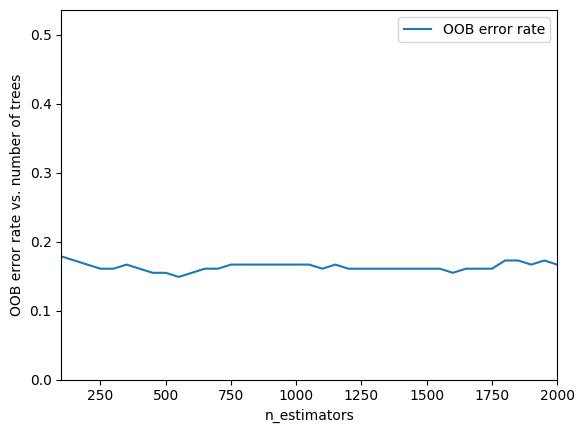

In [26]:
RANDOM_STATE = 0 # Note: if you modifiy the random stat, the results can be sligthly different


# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = []

# Range of `n_estimators` values to explore.
min_estimators = 100
max_estimators = 2000
step=50

for i in range(min_estimators, max_estimators+1, step):
    rf = RandomForestClassifier(warm_start=True, n_estimators=i,random_state=RANDOM_STATE, oob_score=True)
    rf.fit(data, target)

    # Record the OOB error for each `n_estimators=i` setting.
    oob_error = 1 - rf.oob_score_
    error_rate.append(oob_error)
  

# Plot Generate the "OOB error rate" vs. "n_estimators" plot

plt.plot(range(min_estimators, max_estimators +1, step), error_rate, label="OOB error rate")

plt.ylim(0, 3*max(error_rate)) 
plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate vs. number of trees")
plt.legend(loc="upper right")
plt.show()

Solution about the comment of the plot and choice of a suitable value for `n_estimators`: from 750 trees, the oob error seems quite stable. So we can choose `n_estimators`=750 trees.

**Question 4. Now, we will repeat `B` times a `k`-fold cross validation with the function GridSearchCV to calibrate the parameter `max_features`. Complete the command below, comment the results and select suitable value for `max_features`. For `n_estimators`use the value previously selected.**

**Indications:**
- **Consider the following values`max_features = (0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9)`. The values (0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9) for `max_features` represent the proportions of selected features. See the documention of [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) class.**
- **we will repeat `B=3`times a k-fold crossvalidation with `k=5`.**

In [19]:
## Solution

# Step 1: create a grid with all the values that we will considers for the two paramters
grid = {
    'max_features':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
}
# Step 2: use the grid to to search for the best couple of parameters
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
rf = RandomForestClassifier(n_estimators=1000, random_state=0,n_jobs=-1) # create the forest model to tune

B=3
cv_split = RepeatedKFold(n_splits=5, n_repeats=B, random_state=0)
rf_cv = GridSearchCV(estimator=rf,param_grid=grid, cv=cv_split,n_jobs=-1)
rf_cv.fit(data, target) # Fit the CV search


GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=0),
             estimator=RandomForestClassifier(n_estimators=1000, n_jobs=-1,
                                              random_state=0),
             n_jobs=-1,
             param_grid={'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                          0.8, 0.9]})

In [24]:
# Step 3: get the best parameters (with the higher performance)
print(rf_cv.cv_results_)

{'mean_fit_time': array([1.0489329 , 1.2485738 , 1.59923765, 1.8841358 , 2.29848253,
       2.60587591, 2.83389618, 3.20888708, 3.04664591]), 'std_fit_time': array([0.09085972, 0.1468549 , 0.18619112, 0.17496692, 0.14773989,
       0.21057229, 0.15633966, 0.20859901, 0.68328446]), 'mean_score_time': array([0.08261757, 0.10767185, 0.11315757, 0.11081691, 0.11828106,
       0.11117395, 0.10746843, 0.11217278, 0.09234916]), 'std_score_time': array([0.03852639, 0.01043981, 0.01825435, 0.02617095, 0.02254094,
       0.01874193, 0.01633232, 0.01746495, 0.02167052]), 'param_max_features': masked_array(data=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value=1e+20), 'params': [{'max_features': 0.1}, {'max_features': 0.2}, {'max_features': 0.3}, {'max_features': 0.4}, {'max_features': 0.5}, {'max_features': 0.6}, {'max_features': 0.7}, {'max_features': 0.8}, {'max_features': 0.9}],

Solution for the interpretation and the selection of `max_features`: we select 'sqrt' because results are quite stable, so I choose 

**Question 5. Now, replace the value of `max_features`by the one that you selected at the previsou question and check again the optimal value of `n_estimators`when using the optimal value for `max_features`. Comment your result. What value for `n_estimators`do you finally choose ?**


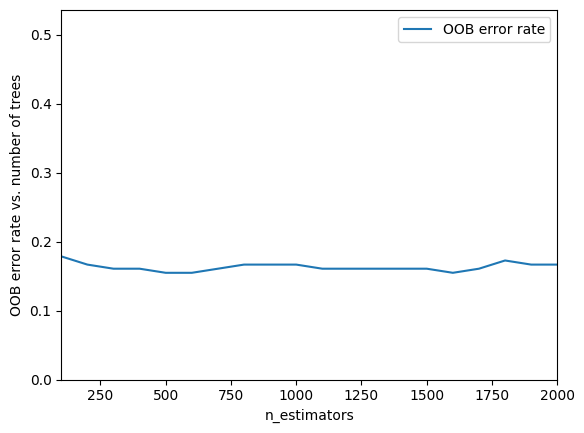

In [37]:
## Solution

import matplotlib.pyplot as plt

RANDOM_STATE = 0 # Note: if you modifiy the random stat, the results can be sligthly different


# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = []

# Range of `n_estimators` values to explore.
min_estimators = 100
max_estimators = 2000
step=100

for i in range(min_estimators, max_estimators+1, step):
    rf = RandomForestClassifier(warm_start=True, n_estimators=i,random_state=RANDOM_STATE, oob_score=True)
    rf.fit(data, target)

    # Record the OOB error for each `n_estimators=i` setting.
    oob_error = 1 - rf.oob_score_
    error_rate.append(oob_error)
  

# Plot Generate the "OOB error rate" vs. "n_estimators" plot

plt.plot(range(min_estimators, max_estimators +1, step), error_rate, label="OOB error rate")

plt.ylim(0, 3*max(error_rate)) 
plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate vs. number of trees")
plt.legend(loc="upper right")
plt.show()

Comment and final choice for `n_estimators`: 750 seems still a good value.

**Question 6. Build the random forest `opt_rfc` by using the best values for the parameters `n_estimators` and `max_features`. Compute the accuracy on the test set and display the confusion matrix.**

Accuracy in opt_rfc:  0.81


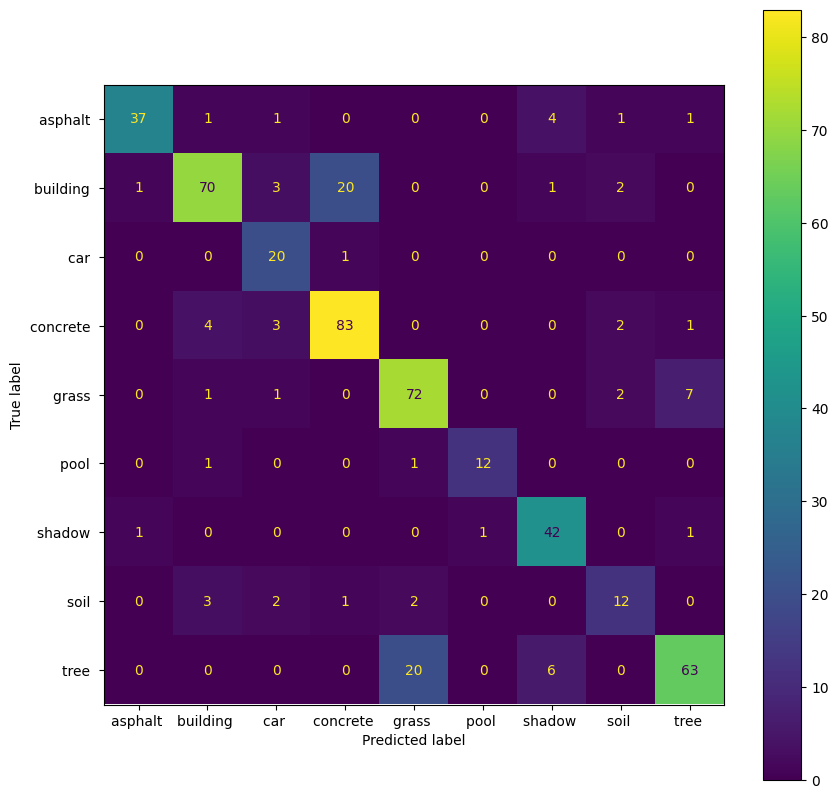

In [40]:
## Solution

# Step 1: fit a random forest with the best values for parameters
opt_rfc = RandomForestClassifier(n_estimators=750,oob_score=True,random_state=0)

# Step 2: build the random forest on the train set by indicating the input data and the target variable 
opt_rfc.fit(data, target)

# Step 3: compute the accuracy and the confusion matrix
predictions_test_2 = opt_rfc.predict(data_test) 
cm_2 = confusion_matrix(target_test, predictions_test_2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_2,display_labels=opt_rfc.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax) 

# Step 4: compute the accuracy
accuracy_2 = opt_rfc.score(data_test,target_test)
print('Accuracy in opt_rfc: ',round(accuracy_2,2))

**Question 7. what value for`max_features` we have to choose if we want to apply the bagging algorithm with CART instead of a random forest ? Build this model and compute the prediction error of this model based on the test set. Compare this model with the two previous random forests. We will call this model $bag$.**

**Indication: use the value selected previously for the parameter `n_estimators`.** 

Accuracy of the bagging model: 0.8


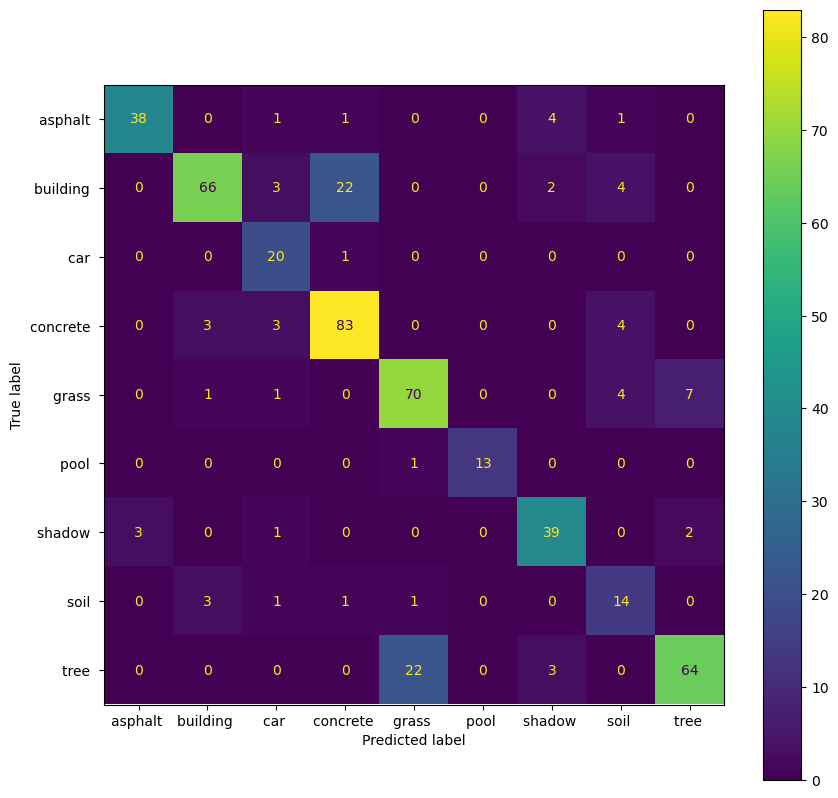

In [40]:
## Solution

# Step 1: fit a a bagging model (use the best value for n_estimators)
bag = RandomForestClassifier(n_estimators=750, max_features=147,oob_score=True,random_state=0)

# Step 2: build the random forest on the train set by indicating the input data and the target variable 
bag.fit(data, target)

# Step 3: compute the prediction on the test set and the confusion matrix
predictions_test_bag = bag.predict(data_test) 
cm_bag = confusion_matrix(target_test, predictions_test_bag)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bag,display_labels=bag.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)  

# Step 4: compute the accuracy on the test set
accuracy_bag = bag.score(data_test,target_test)
print("Accuracy of the bagging model:", round(accuracy_bag,2))

**Question 8. Fit a maximal CART tree on the training set using the [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) class, like in the first lab session. Next, compute the prediction error of this tree based on the test set. Name this tree `single_tree`.**

**Indication: to get the maximal tree, use `max_depth=None` (the default value).**

Accuracy of the maximal CART tree: 0.72


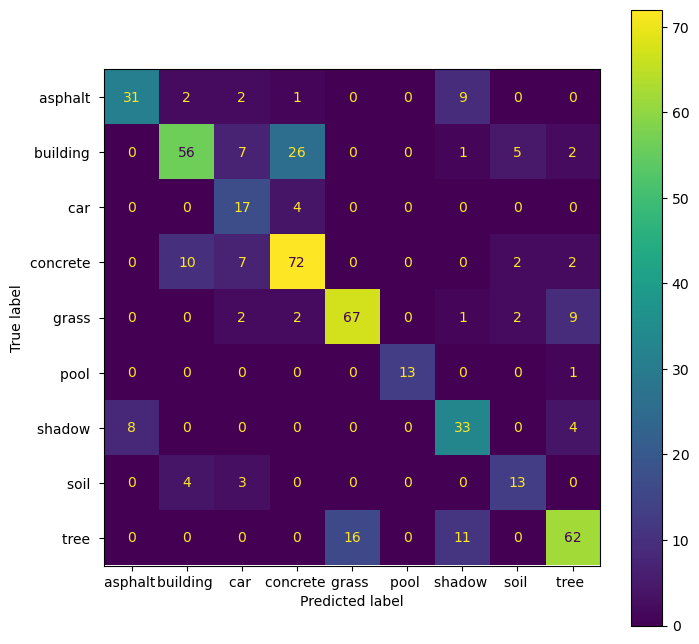

In [36]:
## Solution

# Step 1: Fit the maximum tree 
from sklearn.tree import DecisionTreeClassifier, plot_tree
single_tree = DecisionTreeClassifier(random_state=0)

# Step 2: build the tree on the train set by indicating the input data and the traget variable 
single_tree.fit(data, target)

# Step 3: compute the accuracy and the confusion matrix
predictions_test_tree = single_tree.predict(data_test)
cm_tree = confusion_matrix(target_test, predictions_test_tree)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tree,display_labels=single_tree.classes_)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax) 

# ste 4: compute the accuracy on the test set
accuracy_tree = single_tree.score(data_test,target_test)
print("Accuracy of the maximal CART tree:", round(accuracy_tree,2))

**Question 9. Compare your three models `opt_rfc`, `bag`and `single_tree` using suitable performance criteria. What model do you choose and why ?**

Your Answer: `opt_rfc` and `bag` are quite equivalent in terms of predictive performance. Even though `opt_rfc` slightly outperforms `bag`. These two models have good performances and for these two models, building can be predicted as concret and tree can be predicted as grass (or conversely). The single tree has smaller predictive performance than the two other models. In the single tree, building can be predicted as concret or car, tree can be predicted as grass or shadow and grass can be predicted as tree. 

We choose `opt_rfc` because it has the best predictive performance.




**Question 10. The MDA of each of the 147 features in the dataset has been independently computed `n__repeats` times on the test set (using each time another permutation of each feature). The code below shows the boxplot of the mean decrease in accuracy (MDA) for the 15 features with the highest average MDA.Comment the plot.** 

/var/folders/k7/v1_ly34d72b3gdv9ct9z09p00000gn/T/ipykernel_38758/3122757295.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(result.importances[invert_sorted_idx].T,


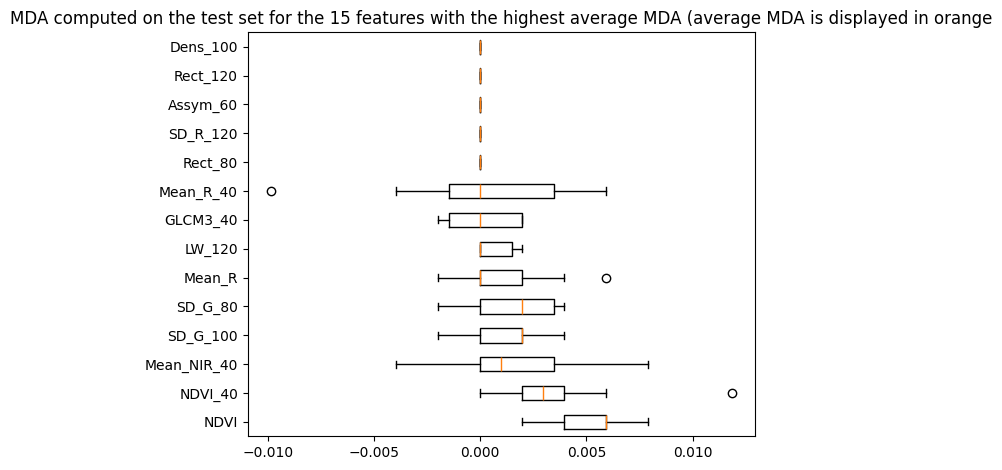

In [41]:
## Computation of the MDA for all features
result = permutation_importance(opt_rfc, data_test, target_test, n_repeats=10, random_state=0, n_jobs=2)


## Plot of the MDA for the 15 features with the highest average MDA
sorted_idx = result.importances_mean.argsort()
invert_sorted_idx=sorted_idx[::-1][:14]# keep only the 15 features with the highest average MDA
fig, ax = plt.subplots()
ax.boxplot(result.importances[invert_sorted_idx].T,
           vert=False, labels=data_test.columns[invert_sorted_idx])
ax.set_title("MDA computed on the test set for the 15 features with the highest average MDA (average MDA is displayed in orange")
fig.tight_layout()
plt.show()

Solution for the comments about the plot: The code below shows the boxplot of the mean decrease in accuracy (MDA) for the 15 features with the highest average MDA. The features with the highest values for the MDA are considered as the most important features in the forest `opt_rfc`. So, here, according to the MDA, the most important features is by far : `NDVI`. The MDA of the other variables are quite similar.

**Question 11. What importance index is stored in `opt_rfc.feature_importances_` ? Use the Python documentation [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) to answer.** 

In [42]:
opt_rfc.feature_importances_

array([0.00454042, 0.00991095, 0.00198986, 0.01383354, 0.00757992,
       0.00446653, 0.01977156, 0.01530049, 0.01491193, 0.00935643,
       0.0074559 , 0.00523134, 0.0020313 , 0.00249996, 0.00261039,
       0.00165082, 0.00167163, 0.00248056, 0.03563942, 0.00813351,
       0.00519702, 0.0041336 , 0.00994709, 0.00132147, 0.0111684 ,
       0.00326651, 0.00370793, 0.01493844, 0.01880644, 0.01638108,
       0.00689829, 0.00482061, 0.00371467, 0.00205398, 0.00191389,
       0.00104356, 0.00183797, 0.00215933, 0.00142058, 0.03646288,
       0.00974631, 0.003481  , 0.00618217, 0.01143619, 0.0024586 ,
       0.0121657 , 0.00240397, 0.00620366, 0.01416307, 0.0118924 ,
       0.01483693, 0.00566799, 0.00348055, 0.00409943, 0.00126357,
       0.00371933, 0.00116416, 0.00378486, 0.00145953, 0.00068714,
       0.03163979, 0.01268617, 0.00297655, 0.00945785, 0.00580261,
       0.00247644, 0.01818331, 0.00221805, 0.01060535, 0.01394336,
       0.01623516, 0.01604967, 0.01052062, 0.00323243, 0.00420

Your answer: `opt_rfc.feature_importances_` shows the mean decrease in impurity (MDI) of each feature.

**Question 12. The code below plot the 30 features with the highest values in `feature_importances_` .Comment the plo and compare with the boxplots in Question 10.** 

<BarContainer object of 15 artists>

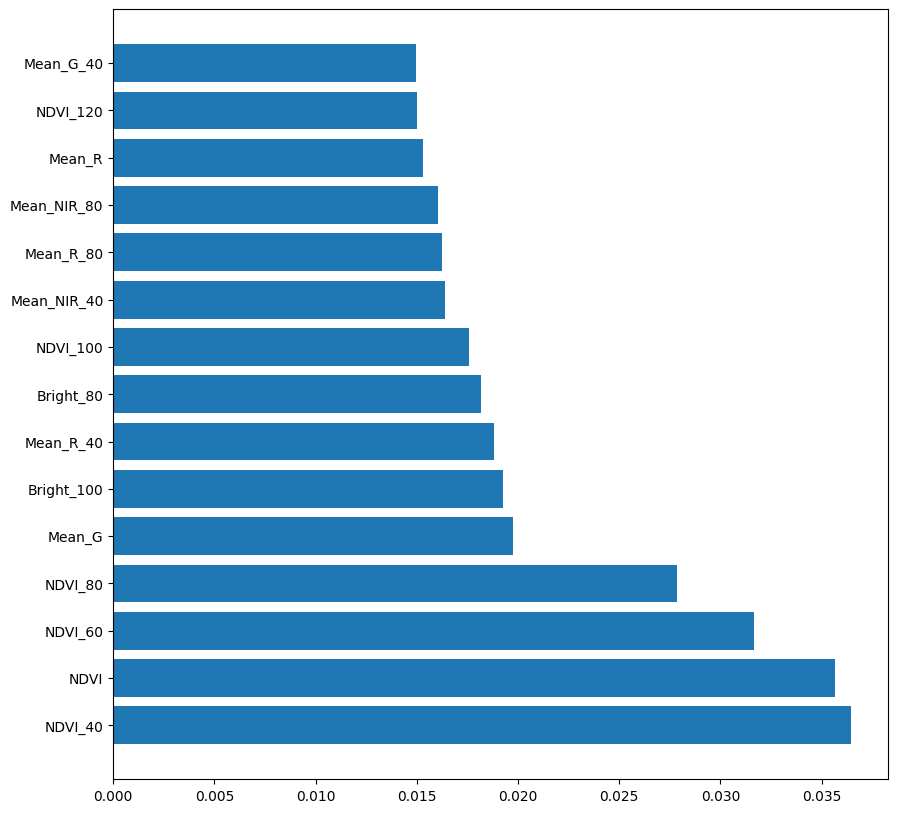

In [44]:
sorted_idx2 = opt_rfc.feature_importances_.argsort()
invert_sorted_idx2=sorted_idx2[::-1][:15]# keep only the 15 features with the highest average MDA
fig = plt.figure(figsize=(10,10))
plt.barh(data.columns[invert_sorted_idx2], opt_rfc.feature_importances_[invert_sorted_idx2])

In [50]:
## features that are part of both the 15 most important features with MDA and with MDI 
np.intersect1d(data.columns[invert_sorted_idx2],data_test.columns[invert_sorted_idx]) 

array(['Mean_G', 'Mean_NIR_40', 'Mean_R', 'Mean_R_40', 'NDVI', 'NDVI_40',
       'ShpIndx_120'], dtype=object)

Comment: according to the MDI, the most important variable is `NDVI` following by `NDVI_40` and `NDVI_60`. MDA and MDI agree for the most important variable and their lists of 15 most important variables shares 7 features in common which are `mean_G`, `Mean_NIR_40`, `Mean_R`, `Mean_R_40`, `NDVI`, `NDVI_40` and `ShpIndx_120`. Nonetheless, the ranking is different.

## Ex 2: discover several variable selection methods

Here, we keep working with the urban dataset. 

**Questions:**
 - 1) **Based on the end of the exercice select a subset of variable and build a new random forest based only the selected subset of features. Justify your choice.**
 - 2) **Apply the function `RFE` from `sklearn.feature_selection` that implement the RFE algorithm and select the best size of subset. Use MDA for the importance measure. Build a new random forest based on the selected subset.**
 - 3) **Apply now the boruta algorithm using the function `BorutaPy`from `boruta`. Don't select a size for the subest of selected features, the size will be determined automatically by the function. Then, build a random forest based on the selected subset.**
 - 4) **Compare all models. What model do you select and why?**
 
 
**Justify all your choices.**

## Below it is a correction with no interpretation and justification. Warning: in practice, all choices must be justified.

### Q1

Comment: we decide to select the 7 features that are selected by both MDI and MDA.


In [17]:
subset1= ['Mean_G', 'Mean_NIR_40', 'Mean_R', 'Mean_R_40', 'NDVI', 'NDVI_40','ShpIndx_120']

Accuracy of rf1: 0.78


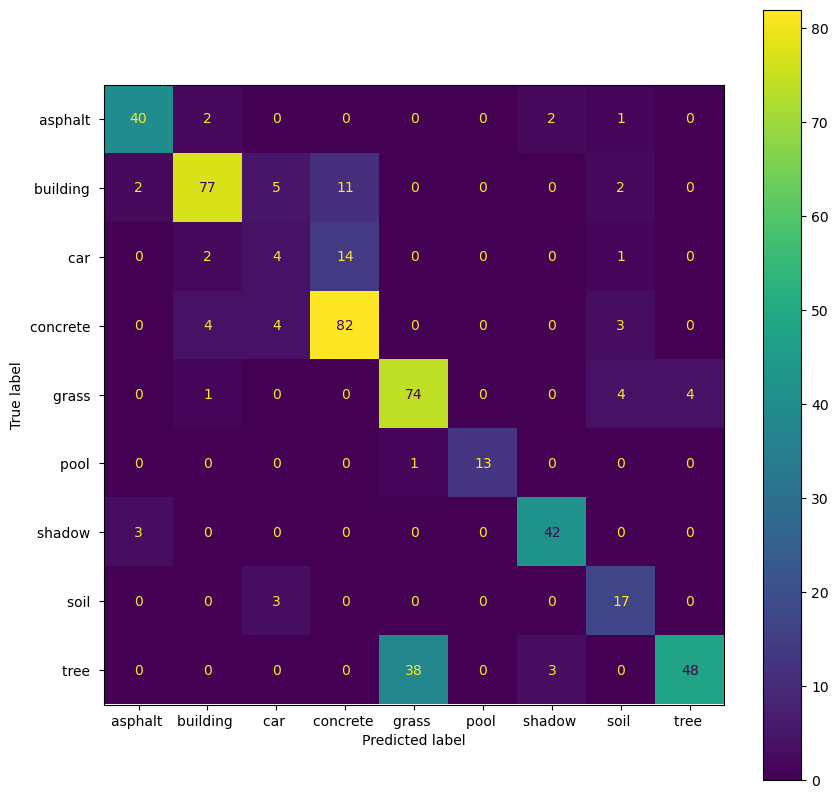

In [18]:
rf1 = RandomForestClassifier(n_estimators=750, max_features='auto',oob_score=True,random_state=0)

rf1.fit(data[subset1], target)

pred1 = rf1.predict(data_test[subset1]) 
cm1 = confusion_matrix(target_test, pred1)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1,display_labels=rf1.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp1.plot(ax=ax)  

# Step 4: compute the accuracy on the test set
acc1 = rf1.score(data_test[subset1],target_test)
print("Accuracy of rf1:", round(acc1,2))

### Q2

Recursive Feature Elimination(RFE) is a feature selection algorithm.
RFE works by searching for a subset of features by starting with all features in the training dataset and successfully removing features until the desired number remains.
This is achieved by at first fitting the model using all the features in a given set, ranking features by importance, then discarding the least important features, and re-fitting the model. This process is repeated until a specified number of features remains.


In [21]:
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

In [28]:
cv_method = KFold(n_splits=3) # 3 folds as in the example

rf = RandomForestClassifier(n_estimators=750, max_features='auto',oob_score=True,random_state=0)
rfecv = RFECV(
    PermutationImportance(rf,  scoring='accuracy', n_iter=1, random_state=0, cv=2 ),
    cv=cv_method,
    scoring='accuracy',
    step=0.1
)

In [30]:
rfecv.fit(data.values, target.values)

PermutationImportance(cv=2,
                      estimator=RandomForestClassifier(n_estimators=750,
                                                       oob_score=True,
                                                       random_state=0),
                      n_iter=1, random_state=0, scoring='accuracy')

In [31]:
rfecv.ranking_

array([6, 5, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 3, 1, 3,
       3, 4, 1, 2, 4, 2, 4, 4, 4, 2, 1, 3, 3, 1, 1, 4, 2, 1, 1, 2, 1, 3,
       1, 1, 1, 2, 1, 1, 4, 5, 5, 4, 5, 5, 1, 5, 1, 6, 5, 6, 1, 7, 5, 6,
       1, 7, 7, 7, 5, 3, 1, 7, 5, 6, 1, 7, 7, 6, 7, 1, 5, 7, 6, 5, 1, 6,
       7, 1, 7, 6, 6, 1, 5, 7, 7, 6, 6, 5, 6, 6, 1, 2, 3, 1, 1, 2, 4, 4,
       1, 1, 1, 2, 1, 1, 1, 3, 3, 1, 3, 3, 4, 4, 3, 1, 4, 4, 3, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1])

In [73]:
rfecv.grid_scores_

array([0.48809524, 0.77380952, 0.81547619, 0.80952381, 0.82142857,
       0.83333333, 0.82738095, 0.82142857, 0.80357143, 0.80357143,
       0.82738095, 0.82142857])

In [75]:
rfecv.n_features_

63

In [72]:
subset2 = [f for f,s in zip(data.columns, rfecv.support_) if s]
print(subset2)

['Round', 'Bright', 'Compact', 'ShpIndx', 'Mean_G', 'Mean_R', 'Mean_NIR', 'LW', 'GLCM1', 'Rect', 'GLCM2', 'Dens', 'NDVI', 'GLCM3', 'Bright_40', 'SD_NIR_40', 'Rect_40', 'GLCM2_40', 'NDVI_40', 'BordLngth_40', 'BrdIndx_60', 'Round_60', 'Bright_60', 'Compact_60', 'Mean_G_60', 'Mean_R_60', 'Rect_60', 'Dens_60', 'GLCM3_60', 'Bright_80', 'SD_G_80', 'GLCM1_80', 'NDVI_80', 'Round_100', 'ShpIndx_100', 'SD_G_100', 'NDVI_100', 'BrdIndx_120', 'Area_120', 'ShpIndx_120', 'Mean_G_120', 'Mean_R_120', 'SD_G_120', 'SD_R_120', 'SD_NIR_120', 'Rect_120', 'GLCM3_120', 'Bright_140', 'ShpIndx_140', 'Mean_G_140', 'Mean_R_140', 'Mean_NIR_140', 'SD_G_140', 'SD_R_140', 'SD_NIR_140', 'LW_140', 'GLCM1_140', 'Rect_140', 'GLCM2_140', 'Dens_140', 'Assym_140', 'NDVI_140', 'GLCM3_140']


Accuracy of rf1: 0.81


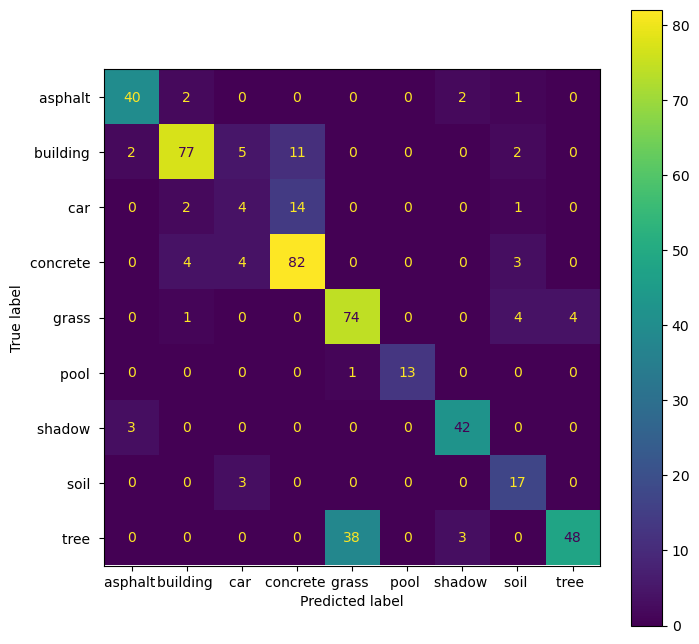

In [104]:
rf2 = RandomForestClassifier(n_estimators=750, max_features='auto',oob_score=True,random_state=0)

rf2.fit(data[subset2], target)

pred2 = rf2.predict(data_test[subset2]) 
cm2 = confusion_matrix(target_test, pred2)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2,display_labels=rf2.classes_)
fig, ax = plt.subplots(figsize=(8,8))
disp1.plot(ax=ax)  

# Step 4: compute the accuracy on the test set
acc2 = rf2.score(data_test[subset2],target_test)
print("Accuracy of rf1:", round(acc2,2))

In [78]:
from sklearn.feature_selection import RFE

rf = RandomForestClassifier(n_estimators=750, max_features='auto',oob_score=True,random_state=0)
rfe = RFE(rf,step=0.1)
rfe.fit(data, target)

RFE(estimator=RandomForestClassifier(n_estimators=750, oob_score=True,
                                     random_state=0),
    step=0.1)

In [82]:
subset3 = [f for f,s in zip(data.columns, rfe.support_) if s]
print(subset3)
print(len(subset3))

['BrdIndx', 'Area', 'Bright', 'Compact', 'Mean_G', 'Mean_R', 'Mean_NIR', 'SD_G', 'SD_R', 'SD_NIR', 'NDVI', 'BordLngth', 'GLCM3', 'BrdIndx_40', 'Area_40', 'Bright_40', 'ShpIndx_40', 'Mean_G_40', 'Mean_R_40', 'Mean_NIR_40', 'SD_G_40', 'SD_R_40', 'NDVI_40', 'BordLngth_40', 'BrdIndx_60', 'Area_60', 'Bright_60', 'ShpIndx_60', 'Mean_G_60', 'Mean_R_60', 'Mean_NIR_60', 'SD_G_60', 'GLCM1_60', 'NDVI_60', 'BordLngth_60', 'BrdIndx_80', 'Area_80', 'Bright_80', 'ShpIndx_80', 'Mean_G_80', 'Mean_R_80', 'Mean_NIR_80', 'SD_G_80', 'GLCM2_80', 'NDVI_80', 'BordLngth_80', 'BrdIndx_100', 'Bright_100', 'ShpIndx_100', 'Mean_G_100', 'Mean_R_100', 'Mean_NIR_100', 'SD_G_100', 'SD_R_100', 'NDVI_100', 'BordLngth_100', 'BrdIndx_120', 'Bright_120', 'ShpIndx_120', 'Mean_G_120', 'Mean_R_120', 'Mean_NIR_120', 'SD_NIR_120', 'NDVI_120', 'BrdIndx_140', 'Bright_140', 'ShpIndx_140', 'Mean_G_140', 'Mean_R_140', 'Mean_NIR_140', 'SD_NIR_140', 'NDVI_140', 'BordLngth_140']
73


Accuracy of rf3: 0.8


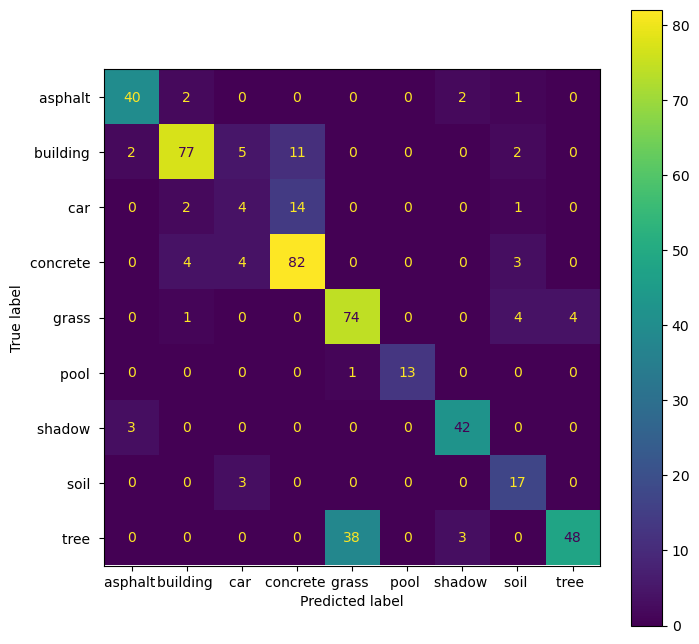

In [102]:
rf3 = RandomForestClassifier(n_estimators=750, max_features='auto',oob_score=True,random_state=0)

rf3.fit(data[subset3], target)

pred3= rf3.predict(data_test[subset3]) 
cm3 = confusion_matrix(target_test, pred3)
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm3,display_labels=rf3.classes_)
fig, ax = plt.subplots(figsize=(8,8))
disp1.plot(ax=ax)  

# Step 4: compute the accuracy on the test set
acc3 = rf3.score(data_test[subset3],target_test)
print("Accuracy of rf3:", round(acc3,2))

### Q3

Boruta is an iterative feature selection algorithm based on the random forest algorithm. At each iteration, the algorithm creates random shuffle copies of the original features. Then, a random forest is trained on the extended data that included both the original features and their respective shuffled copies. To measure the importance of each feature, the algorithm computes a Z score on each feature and compares it to a threshold defined as the maximum Z score of all shuffle copies. Then, only variables for which importance is significantly higher than the threshold are kept in the model while the others are removed. This process is repeated until either all features are labeled as important/non-important or until the maximum number of iterations is reached. 

In [92]:
from boruta import BorutaPy

In [93]:
rf = RandomForestClassifier(n_estimators=750,n_jobs=-1, max_features='auto',oob_score=True,random_state=0)
rf.fit(data, target)
# define Boruta feature selection method
boruta = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=1)

# find all relevant features
boruta.fit(data.values, target.values)

BorutaPy(estimator=RandomForestClassifier(n_estimators=145, n_jobs=-1,
                                          oob_score=True,
                                          random_state=RandomState(MT19937) at 0x7FCB9B84AC00),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7FCB9B84AC00)

In [94]:
# check selected features
boruta.support_

array([ True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
        True,  True,  True,  True,  True, False,  True, False,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False,  True,  True,  True,  True,  True, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True, False, False,  True,  True,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True,  True,  True, False, False, False,  True, False, False,
        True,  True, False,  True, False, False,  True, False,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False,  True,  True, False,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False,  True, False,  True,  True, False,
        True, False,

In [95]:
# check ranking of features
boruta.ranking_

array([ 1,  1, 14,  1,  1,  1,  1,  1,  1,  1,  1,  1, 37, 26,  2, 24, 23,
       16,  1,  1,  1,  1,  1, 38,  1,  2,  1,  1,  1,  1,  1,  1,  1, 25,
        9, 37, 18, 10, 47,  1,  1,  1,  1,  1, 33,  1, 16,  1,  1,  1,  1,
        1,  1,  1, 45,  1, 50,  1, 39, 49,  1,  1,  1,  1,  1,  7,  1, 14,
        1,  1,  1,  1,  1,  1,  1, 40,  2, 49,  1, 20, 46,  1,  1,  3,  1,
        3,  3,  1,  2,  1,  1,  1,  1,  1,  1,  1, 35, 43, 42,  9, 11, 33,
        1,  1, 22,  1,  3,  7,  1,  1,  1,  1,  1,  1,  1,  1,  1, 44, 27,
       28, 21,  1, 12,  1,  1, 35,  1,  3,  3,  1,  2,  1,  1,  1,  1,  1,
        1,  1, 31, 30, 30, 16,  2, 20,  1,  1, 42])

In [96]:
subset4 = [f for f,s in zip(data.columns, boruta.support_) if s]
print(subset4)
print(len(subset4))

['BrdIndx', 'Area', 'Bright', 'Compact', 'ShpIndx', 'Mean_G', 'Mean_R', 'Mean_NIR', 'SD_G', 'SD_R', 'SD_NIR', 'NDVI', 'BordLngth', 'GLCM3', 'BrdIndx_40', 'Area_40', 'Bright_40', 'ShpIndx_40', 'Mean_G_40', 'Mean_R_40', 'Mean_NIR_40', 'SD_G_40', 'SD_R_40', 'SD_NIR_40', 'NDVI_40', 'BordLngth_40', 'GLCM3_40', 'BrdIndx_60', 'Area_60', 'Bright_60', 'ShpIndx_60', 'Mean_G_60', 'Mean_R_60', 'Mean_NIR_60', 'SD_G_60', 'SD_R_60', 'SD_NIR_60', 'GLCM1_60', 'GLCM2_60', 'NDVI_60', 'BordLngth_60', 'GLCM3_60', 'BrdIndx_80', 'Area_80', 'Bright_80', 'ShpIndx_80', 'Mean_G_80', 'Mean_R_80', 'Mean_NIR_80', 'SD_G_80', 'SD_R_80', 'SD_NIR_80', 'GLCM2_80', 'NDVI_80', 'BordLngth_80', 'BrdIndx_100', 'Bright_100', 'ShpIndx_100', 'Mean_G_100', 'Mean_R_100', 'Mean_NIR_100', 'SD_G_100', 'SD_R_100', 'SD_NIR_100', 'NDVI_100', 'BordLngth_100', 'BrdIndx_120', 'Bright_120', 'Compact_120', 'ShpIndx_120', 'Mean_G_120', 'Mean_R_120', 'Mean_NIR_120', 'SD_G_120', 'SD_R_120', 'SD_NIR_120', 'Dens_120', 'NDVI_120', 'BordLngth_120'

Accuracy of rf4: 0.82


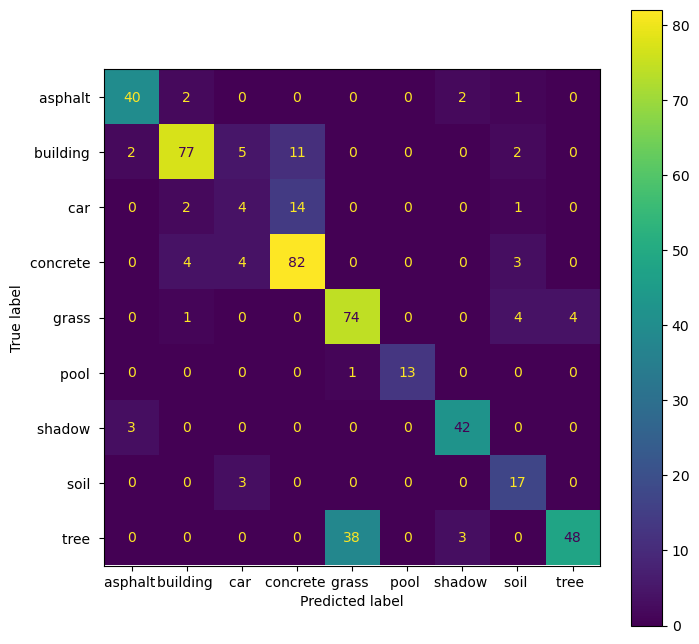

In [103]:
rf4 = RandomForestClassifier(n_estimators=750, max_features='auto',oob_score=True,random_state=0)

rf4.fit(data[subset4], target)
pred4= rf4.predict(data_test[subset4]) 
cm4 = confusion_matrix(target_test, pred3)
disp4 = ConfusionMatrixDisplay(confusion_matrix=cm4,display_labels=rf4.classes_)
fig, ax = plt.subplots(figsize=(8,8))
disp1.plot(ax=ax)  

# Step 4: compute the accuracy on the test set
acc4 = rf4.score(data_test[subset4],target_test)
print("Accuracy of rf4:", round(acc4,2))

### Q4

Indications:
- Compare the several subset. Do they share lots of variables ? Do they have similar size ?
- Compare model results : 
    - in terms of prediction performance (do not just look at the accuracy bu also look at the classes that are misclassified so look at the confusion matrix)
    - in terms of interpretability